# Paraphrase-Detection using Bi-LSTM with Gated Relevance Network
Paraphrase detection is the task of examining two text entities (ex. sentence) and determining whether they have the same meaning. In order to obtain high accuracy on this task, thorough syntactic and semantic analysis of the two text entities is required.

## What is Paraphrase?
In simple words, paraphrase is just an alternative representation of the same meaning.

![text_similarity.png](text_similarity.png)

## Quora Question Pairs Dataset
There are over 400,000 lines of potential question duplicate pairs. Each line contains IDs for each question in the pair, the full text for each question, and a binary value that indicates whether the line truly contains a duplicate pair.

We can download dataset from [Quora Question Pairs Dataset](https://www.kaggle.com/quora/question-pairs-dataset)

In [0]:
# Importing packages
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import string
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation,MaxPooling2D,Bidirectional,Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix
import spacy
sp = spacy.load('en_core_web_sm')
# import nltk
# nltk.download("punkt")

## Read Dataset

In [0]:
project_path = 'paraphrase_detection/'

In [0]:
data = pd.read_csv(project_path+"questions.csv",nrows=10000)
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Preprocess Data

In [0]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
def clean_question(text):
    doc = sp(text)
    # tokenize
    # text = text.split()
    # Lemmatization
    text = [token.lemma_ for token in doc]
    # convert to lower case
    text = [word.lower() for word in text]
    # remove punctuation from each token
    text = [w.translate(table) for w in text]
    # remove hanging 's' and 'a'
    text = [word for word in text if len(word)>1]
    # remove tokens with numbers in them
    text = [word for word in text if word.isalpha()]
    # store as string
    return ' '.join(text)

In [0]:
data["question1"] = data["question1"].apply(lambda x:clean_question(x))
data["question2"] = data["question2"].apply(lambda x:clean_question(x))

In [0]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what be the step by step guide to invest in sh...,what be the step by step guide to invest in sh...,0
1,1,3,4,what be the story of kohinoor koh noor diamond,what would happen if the indian government ste...,0
2,2,5,6,how can pron increase the speed of pron intern...,how can internet speed be increase by hack thr...,0
3,3,7,8,why be pron mentally very lonely how can pron ...,find the remainder when be divide by,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


## Feature Extraction

In [0]:
# fit a tokenizer with questions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["question1"].values+data["question2"].values)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 17723


In [0]:
# create sequences
max_len = 25
q1_texts_seq = tokenizer.texts_to_sequences(data["question1"].values)
q2_texts_seq = tokenizer.texts_to_sequences(data["question2"].values)

q1_texts_seq = pad_sequences(q1_texts_seq,maxlen=max_len)
q2_texts_seq = pad_sequences(q2_texts_seq,maxlen=max_len)

In [0]:
if os.path.isdir('glove') == False:
    os.mkdir('glove')

glove_dir = "datasets/"
from zipfile import ZipFile
with ZipFile(glove_dir+'glove.zip', 'r') as z:
  z.extractall("glove")

In [0]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open(os.path.join("glove/", 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
X = np.stack((q1_texts_seq, q2_texts_seq), axis=1)
y = data["is_duplicate"].values

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
# Get Question 1/2  train and test features
q1_X_train = X_train[:,0]
q2_X_train = X_train[:,1]

q1_X_test = X_test[:,0]
q2_X_test = X_test[:,1]

## Build Model

Lets build **Bidirectional Long Short-Term Memory with Gated Relevance Network** for Paraphrase Detection

In [0]:
class GatedRelevanceNetwork(Layer):
    def __init__(self, output_dim,
            weights_initializer="glorot_uniform",
            bias_initializer="zeros", **kwargs):
        self.output_dim = output_dim
        self.weights_initializer = weights_initializer
        self.bias_initializer = bias_initializer
        super(GatedRelevanceNetwork, self).__init__(**kwargs)

    def build(self, input_shape):
        batch_size, len1, emb_dim = input_shape[0]
        _, len2, _ = input_shape[1]
        # Weights initialization
        # Bilinear Tensor Product weights
        self.Wb = self.add_weight(name='weights_btp',
                                  shape=(self.output_dim, emb_dim, emb_dim),
                                  initializer=self.weights_initializer,
                                  trainable=True)

        # Single Layer Network weights
        self.Wd = self.add_weight(name='weights_sln',
                                  shape=(2*emb_dim, self.output_dim),
                                  initializer=self.weights_initializer,
                                  trainable=True)

        # Gate weights
        self.Wg = self.add_weight(name='weights_gate',
                                  shape=(2*emb_dim, self.output_dim),
                                  initializer=self.weights_initializer,
                                  trainable=True)

        # Gate bias
        self.bg = self.add_weight(name='bias_gate',
                                  shape=(self.output_dim,),
                                  initializer=self.bias_initializer,
                                  trainable=True)

        # General bias
        self.b = self.add_weight(name='bias',
                                 shape=(self.output_dim,),
                                 initializer=self.bias_initializer,
                                 trainable=True)

        # Channel weights
        self.u = self.add_weight(name="channel_weights",
                                 shape=(self.output_dim, 1),
                                 initializer=self.weights_initializer,
                                 trainable=True)

        super(GatedRelevanceNetwork, self).build(input_shape)

    def call(self, x):
        e1 = x[0]
        e2 = x[1]

        batch_size = K.shape(e1)[0]
        # Usually len1 = len2 = max_seq_length
        _, len1, emb_dim = K.int_shape(e1)
        _, len2, _ = K.int_shape(e2)

        # Repeating the matrices to generate all the combinations
        ne1 = K.reshape(K.repeat_elements(K.expand_dims(e1, axis=2), len2, axis=2),
                       (batch_size, len1*len2, emb_dim))
        ne2 = K.reshape(K.repeat_elements(K.expand_dims(e2, axis=1), len1, axis=1),
                       (batch_size, len1*len2, emb_dim))

        # Repeating the second matrix to use in Bilinear Tensor Product
        ne2_k = K.repeat_elements(K.expand_dims(ne2, axis=-1), self.output_dim, axis=-1)

        # Bilinear tensor product
        btp = K.sum(ne2_k * K.permute_dimensions(K.dot(ne1, self.Wb), (0,1,3,2)), axis=2)
        btp = K.reshape(btp, (batch_size, len1, len2, self.output_dim))

        # Concatenating inputs to apply Single Layer Network
        e = K.concatenate([ne1, ne2], axis=-1)

        # Single Layer Network
        #sln = K.relu(K.dot(e, self.Wd))
        sln = K.tanh(K.dot(e, self.Wd))
        sln = K.reshape(sln, (batch_size, len1, len2, self.output_dim))

        # Gate
        g = K.sigmoid(K.dot(e, self.Wg) + self.bg)
        g = K.reshape(g, (batch_size, len1, len2, self.output_dim))

        # Gated Relevance Network
        #s = K.reshape(K.dot(g*btp + (1-g)*sln + self.b, self.u), (batch_size, len1, len2))
        s = K.dot(g*btp + (1-g)*sln + self.b, self.u)

        return s

    def compute_output_shape(self, input_shape):
        shape1 = input_shape[0]
        shape2 = input_shape[1]
        return (shape1[0], shape1[1], shape2[1], 1)

In [0]:
def create_model(input_shape,
                      embeddings_dim, embeddings_matrix, vocab_size,
                      max_seq_length, trainable_embeddings, dropout,
                      lstm_hidden_units, attention_channels, pool_size,
                      fc_hidden_units):
   
    X1_input = Input(input_shape, name="input_X1")
    X2_input = Input(input_shape, name="input_X2")

    # Encoding the inputs using the same weights
    # Output shape: (batch_size, max_seq_length, lstm_hidden_units)
    embeddor = Embedding(vocab_size,
                    embeddings_dim,
                    weights=[embeddings_matrix],
                    input_length=input_shape[0],
                    trainable=trainable_embeddings,
                    mask_zero=False)
    X1 = embeddor(X1_input)
    X2 = embeddor(X2_input)

    encoder = Bidirectional(LSTM(lstm_hidden_units, return_sequences=True))

    # Output shape: (batch_size, max_seq_length, lstm_hidden_units)
    X1_encoded = encoder(X1)
    X2_encoded = encoder(X2)

    # Attention matrix
    # Output shape: (batch_size, max_seq_length, max_seq_length, 1)
    X = GatedRelevanceNetwork(attention_channels, name="grn")([X1_encoded, X2_encoded])
    #X = BatchNormalization()(X)

    # Non-overlapping 2D max pooling
    # Output shape: (batch_size, pooled_rows, pooled_cols, 1)
    print("shape before pool", X.shape)
    X = MaxPooling2D(pool_size=(pool_size, pool_size),
                        strides=(pool_size, pool_size),
                        padding='valid',
                        data_format="channels_last",
                        name="max_pool")(X)
    X = Flatten()(X)

    # Multi-Layer Perceptron
    #X = Dropout(dropout)(X)
    X = Dense(fc_hidden_units, activation="tanh", name="mlp")(X)
    X = Dropout(dropout)(X)
    X = Dense(2, activation="softmax", name="output")(X)

    model = Model(inputs=[X1_input, X2_input], outputs=X, name="GRN_model")
    # Compiling model
    #optimizer = optimizers.Adam(lr=0.001)
    optimizer = optimizers.RMSprop()
    model.compile(optimizer=optimizer,
                loss="binary_crossentropy",
                metrics=["accuracy"])
    return model

In [0]:
dropout = 0.5
trainable_embeddings = False
lstm_hidden_units = 50
attention_channels = 2
pool_size = 3
fc_hidden_units = 128
use_class_weight = False
input_shape = (max_len,)
model = create_model(input_shape,
                      embedding_dim, embedding_matrix, vocab_size,
                      max_len, trainable_embeddings, dropout,
                      lstm_hidden_units, attention_channels, pool_size,
                      fc_hidden_units)
model.summary()

shape before pool (?, 100, 100, 1)
Model: "GRN_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_X1 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_X2 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 200)     3544600     input_X1[0][0]                   
                                                                 input_X2[0][0]                   
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 100)     10

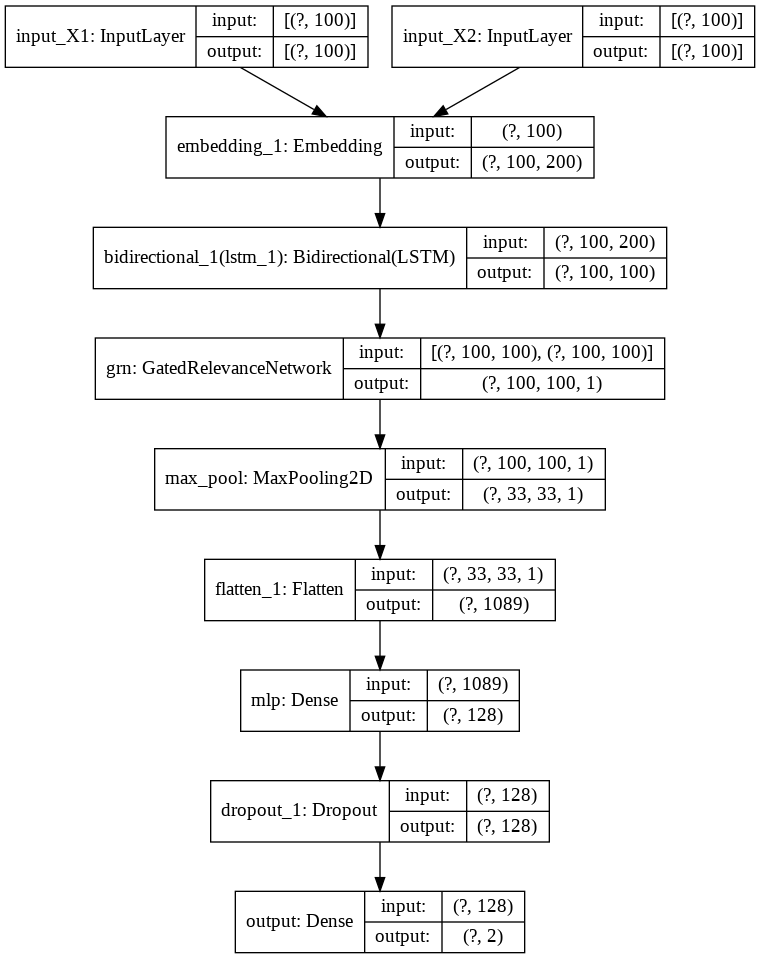

In [0]:
plot_model(model, to_file='model.png', show_shapes=True)

In [0]:
# Defining a helper function to save the model after each epoch 
# in which the loss decreases 
# filepath = project_path+'model_paraprase_detection_pad.h5'
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Defining a helper function to reduce the learning rate each time 
# the learning plateaus 
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
# stop traning if there increase in loss
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
callbacks = [reduce_alpha] 

In [0]:
epochs = 30
batch_size = 64
history = model.fit(x=[q1_X_train, q2_X_train],
                    y=to_categorical(y_train),
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=([q1_X_test, q2_X_test], to_categorical(y_test)),callbacks=callbacks)

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 72s 9ms/sample - loss: 0.3510 - acc: 0.8445 - val_loss: 0.7133 - val_acc: 0.6815
Epoch 2/30
8000/8000 [==============================] - 71s 9ms/sample - loss: 0.2845 - acc: 0.8808 - val_loss: 0.8696 - val_acc: 0.6610
Epoch 3/30
8000/8000 [==============================] - 71s 9ms/sample - loss: 0.2204 - acc: 0.9075 - val_loss: 0.9559 - val_acc: 0.6595
Epoch 4/30
8000/8000 [==============================] - 71s 9ms/sample - loss: 0.1699 - acc: 0.9326 - val_loss: 1.0825 - val_acc: 0.6590
Epoch 5/30
8000/8000 [==============================] - 72s 9ms/sample - loss: 0.1285 - acc: 0.9519 - val_loss: 1.2959 - val_acc: 0.6485
Epoch 6/30
8000/8000 [==============================] - 72s 9ms/sample - loss: 0.1002 - acc: 0.9628 - val_loss: 1.5199 - val_acc: 0.6635
Epoch 7/30
8000/8000 [==============================] - 71s 9ms/sample - loss: 0.0814 - acc: 0.9704 - val_loss: 1.6673 - val_acc: 

In [0]:
filepath = project_path+'model_paraprase_detection_pad.h5'
model.save_weights(filepath)

In [0]:
print("Evaluation (loss, acc)")
loss, acc = model.evaluate(x=[q1_X_test, q2_X_test], y=to_categorical(y_test))
print("loss: {:.4f}   acc: {:.4f}".format(loss, acc))
pred = np.argmax(model.predict(x=[q1_X_test, q2_X_test]), axis=1)
f1 = f1_score(y_test, pred)
print("f1: {:.4f}".format(f1))
print("confusion matrix")
cf_mat = confusion_matrix(y_test, pred)
print(cf_mat)

Evaluation (loss, acc)
2000/2000 [==============================] - 10s 5ms/sample - loss: 2.7165 - acc: 0.6580
loss: 2.7165   acc: 0.6580
f1: 0.5581
confusion matrix
[[884 373]
 [311 432]]
